In [3]:
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import itertools
from scipy.fft import ifftn, fftn
import imageio

In [4]:
def create_Te_cube(ref_cube, Te, R, resolution):

    '''
    Input:
    Ref cube: True 3D cube with emissivities.
    Te: True Te (T0) radial profile from the cloudy model grid
    R: True radius 
    resolution: 

    Output:
    

    '''

    ref_shape = ref_cube.shape
    cube = np.zeros(ref_shape)
    z = np.arange(ref_shape[0])
    y = np.arange(ref_shape[1])
    x = np.arange(ref_shape[2])
    center = np.divide(ref_shape, 2)
   
    r = R * resolution # resolution is in pix/parsec
    Te_interp = interp1d(r, Te, kind='cubic', fill_value=0, bounds_error=False) 
    factor = ref_shape[0]/ref_shape[2]

    
    for i in z:
        for j in y:
            for k in x:
                rad = np.sqrt((i-center[0])**2 + (j-center[1])**2 + factor**2*(k-center[2])**2)
                
                cube[i, j, k] = Te_interp(rad)

    return cube



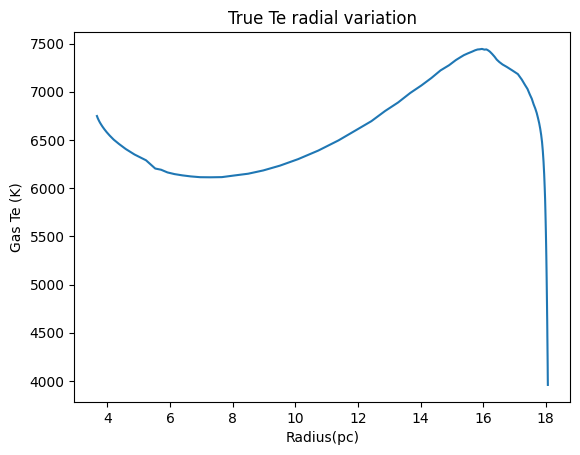

In [5]:
#Radius’, 'Te', 'ne', 'H+', 'O0', 'O+', 'O++', 'N0', 'N+', 'N++', 'S0', 'S+', 'S++

with fits.open('/home/amrita/LVM/lvmnebular/Bubble_v2_5e-14/testneb_tutorial3_ex1.fits') as hdu:
    vals=hdu['Comp_0_PhysParams'].data
R = vals[0][1:]
Te = vals[1][1:]

fig, ax3=plt.subplots()
ax3.plot(R, Te, label='True Te')
ax3.set_xlabel('Radius(pc)')
ax3.set_ylabel('Gas Te (K)')
ax3.set_title('True Te radial variation')
plt.show()

with fits.open('cube_3D_cart.fits') as hdu:
    data=hdu[0].data

resolution = 1/0.777  # in pixels

cube=create_Te_cube(data, Te, R, resolution)

hdu1=fits.PrimaryHDU(cube)

hdul=fits.HDUList([hdu1])
hdul.writeto('3d_cube_Te.fits', overwrite='True')


In [6]:
# From the next block we are making the perturbation cube

In [7]:
def k_vector(npoints):
    k1 = np.arange(npoints/2+1)
    k2 = np.arange(-npoints/2+1, 0)
    
    kvector = 2*np.pi/ npoints* np.concatenate([k1, k2])
    return kvector

def pk_vector_delta(kvector, kvector2, ref_shape, k0, dk0):
    
    npoints = len(kvector)
    kk = np.zeros(ref_shape)
    
    factor = ref_shape[2]/ref_shape[0]  

    print(factor)

    for i, j, k in itertools.product(range(ref_shape[0]), range(ref_shape[1]), range(ref_shape[2])):
        kk[i, j, k] = np.sqrt(kvector[i]**2 + kvector[j]**2 + factor**2*kvector2[k]**2)
               
    
    pk=np.zeros_like(kk)
    sel=(kk > k0-dk0/2)*(kk < k0+dk0/2)
    pk[sel]=1
    
    hdu1=fits.PrimaryHDU(pk)

    hdul=fits.HDUList([hdu1])
    hdul.writeto('power_vector_delta.fits', overwrite='True')

   
    #xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
    #r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)

    #mask = r > npoints/2
    #mask2 = r < 0.8 * npoints/2
    #pk[mask*mask2]=0
    #pk[mask]=0

    pk[0,0,0] = 0
    
    return pk

def field_delta(k0, dk0, ref_cube):
    ref_shape = ref_cube.shape
    
    npoints = ref_shape[0]
    k = k_vector(npoints)
    k2 = k_vector(ref_shape[2])

    pk = pk_vector_delta(k, k2, ref_shape, k0, dk0)
    Pk1 = np.zeros_like(pk)
    #Pk1 /= Pk1.sum()
    Pk1 = pk

    field=np.random.randn(*ref_shape)
    fft_field=fftn(field)
    
    pspect_field = np.sqrt(Pk1) * fft_field
    new_field = np.real(ifftn(pspect_field))
    
    return new_field


In [56]:
def pc2k(x, L=36):
    return L/(2*np.pi*x) # returns k-number corresponding to scale x in pc

def fsr2k(x, L=2):
    return L/(2*np.pi*x) # returns k-number corresponding to a fraction of the Stromgren Radius

def pertsim(ref_cube, n=3, k0=fsr2k(0.5), dk0=0.05, Amp=0.1):
             
    new_field=field_delta(k0, dk0, ref_cube)
                             
    norm_field=new_field/np.std(new_field)*Amp

    return norm_field

In [57]:
perturbed_cube = pertsim(cube) 

hdu1=fits.PrimaryHDU(perturbed_cube)

hdul=fits.HDUList([hdu1])
hdul.writeto('perturbed_cube.fits', overwrite='True')

p_temp = cube*(1+perturbed_cube)

hdu1=fits.PrimaryHDU(p_temp)

hdul=fits.HDUList([hdu1])
hdul.writeto('p_temp.fits', overwrite='True')

2.0408163265306123
0.0 7.852345898950189


In [ ]:
#Below this is a function written to compute perturbations in emissivities

In [58]:
def compute_demissivity(chi, T0, Tp):

    k = 1.38e-23
    A = -chi/(k*Tp)
    B = chi/(k*T0)
    C = np.sqrt(Tp)

    de = np.exp(A+B)/C * np.sqrt(T0)

    return de 

In [59]:
l5007 = compute_demissivity(3.96e-19, cube, p_temp)  #chi = 3.96e-19 J/K for [OIII] 5007 line

hdu1=fits.PrimaryHDU(l5007)

hdul=fits.HDUList([hdu1])
hdul.writeto('d5007.fits', overwrite='True')

/tmp/ipykernel_2471/3133060388.py:4: RuntimeWarning: divide by zero encountered in divide
  A = -chi/(k*Tp)
/tmp/ipykernel_2471/3133060388.py:5: RuntimeWarning: divide by zero encountered in divide
  B = chi/(k*T0)
/tmp/ipykernel_2471/3133060388.py:8: RuntimeWarning: invalid value encountered in add
  de = np.exp(A+B)/C * np.sqrt(T0)


In [28]:
hdu=fits.open('/home/amrita/LVM/lvmnebular/Bubble_v2_5e-14/testneb_tutorial3_ex1.fits')


In [46]:
#for i in range(len(hdu)):
#    if i!=0:
#        print(i, hdu[i].header['EXTNAME'])


np.max(hdu[0].data)

5e-12